# 19. Дополнительные главы теории вероятностей

In [1]:
import sys
sys.path.append("/Users/PredatoryMink/Statistics")

import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import scipy.optimize as opt
import scipy.special as sp
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm
from mystats.utils import plot
from mystats.criterion import fit as myfit

### Задание 1

In [2]:
C = 2
N = 14
L = C * 2**N
K = 1000

cnt = np.zeros(K, int)
for i in range(K):
    x = st.bernoulli(0.5).rvs(L)
    cur = 0
    for j in range(L):
        if x[j] == 0:
            cur = 0
        else:
            cur += 1
            if cur == N:
                cnt[i] += 1            

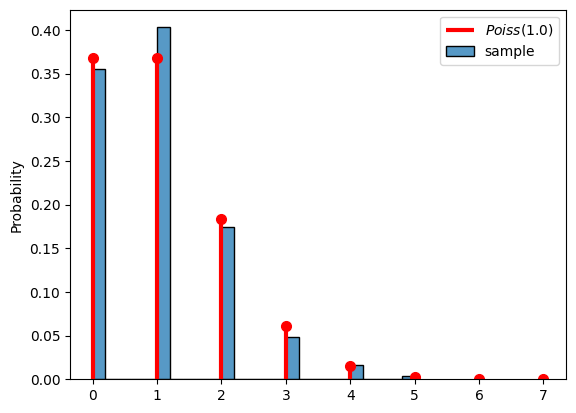

In [3]:
sns.histplot(cnt, stat='probability', label="sample");

a = C / 2
x = np.arange(0, 8, dtype=int)
y = st.poisson(a).pmf(x)
plt.plot(x, y, 'o', c='r', ms=7)
plt.vlines(x, 0, y, colors='r', lw=3, label=fr"$Poiss({a})$")
plt.legend();

### Задание 2

In [4]:
def test_clt(c=1, K=10000, Ns=None):
    if Ns is None:
        Ns = [50, 100, 200, 500, 1000, 5000, 10000]
    ncols = 3
    nrows = len(Ns) // 3 + (1 if len(Ns) % 3 else 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    xs = np.linspace(-3.5, 3.5, 200)
    ys = st.norm.pdf(xs)
    for n, ax in zip(Ns, axes.ravel()):
        t = int(c * n)
        x = st.multinomial(t, [1/n]*n).rvs(K)
        cnt = np.count_nonzero(x == 0, axis=1)
        p = (1 - 1/n)**t
        mu = n * p
        var = n * p * (1 - p) + n * (n - 1) * ((1 - 2 / n)**t - p**2)
        z = (cnt - mu) / mt.sqrt(var)
        ax.set_title(fr"$n = {n}$")
        ax.plot(xs, ys, c='r', lw=3)
        sns.histplot(z, stat='density', ax=ax)

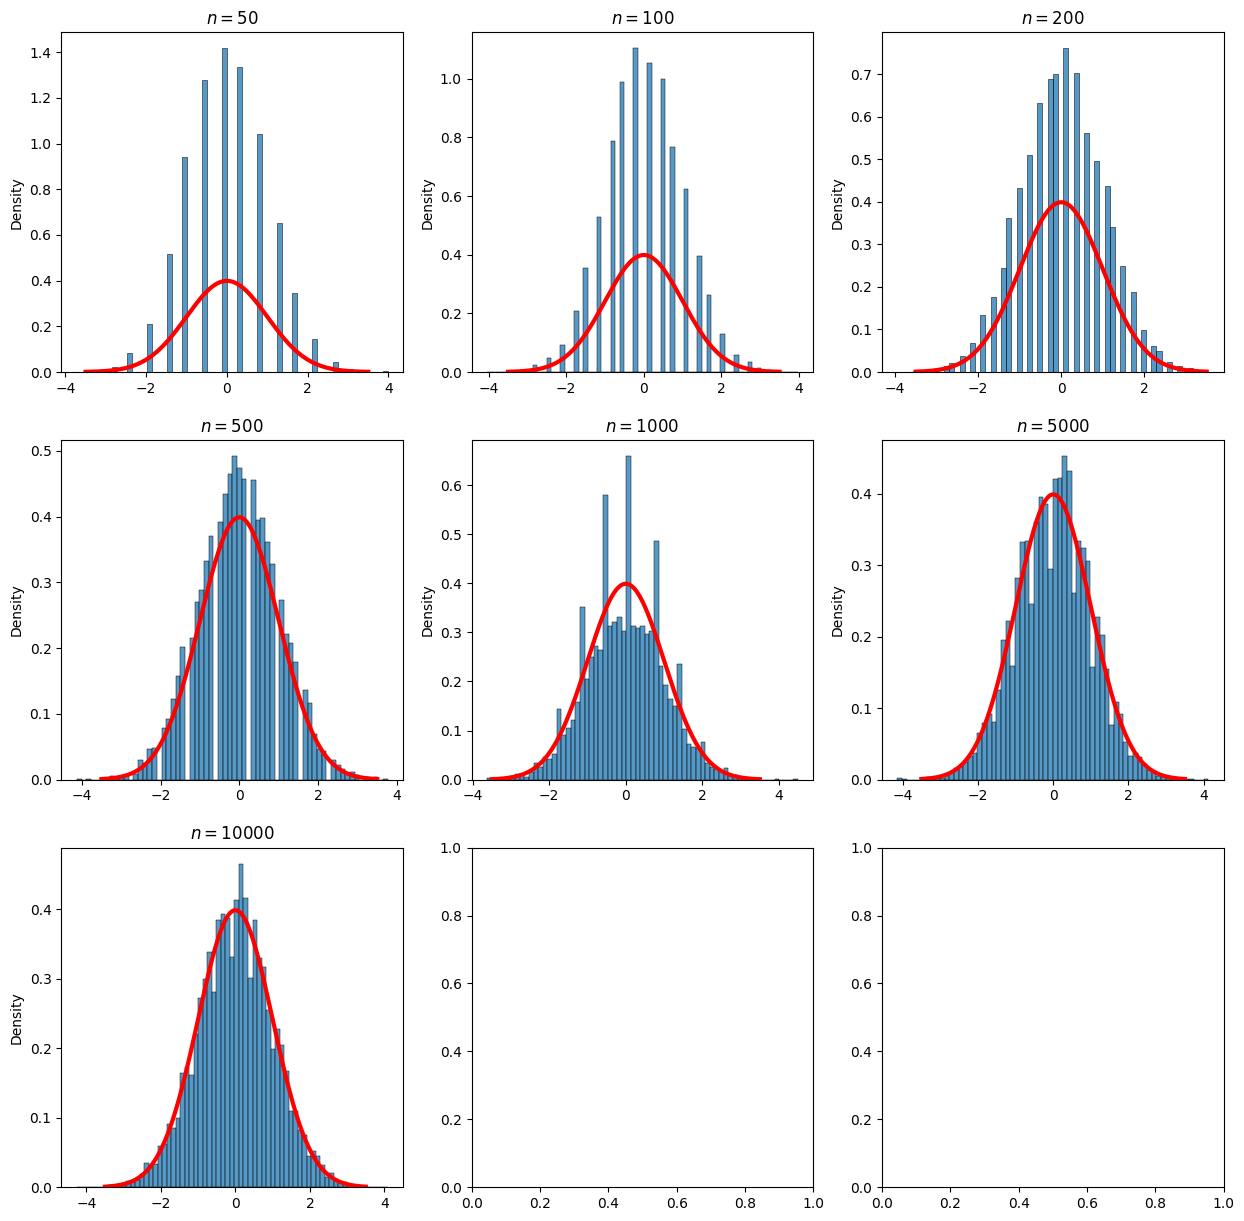

In [5]:
test_clt()

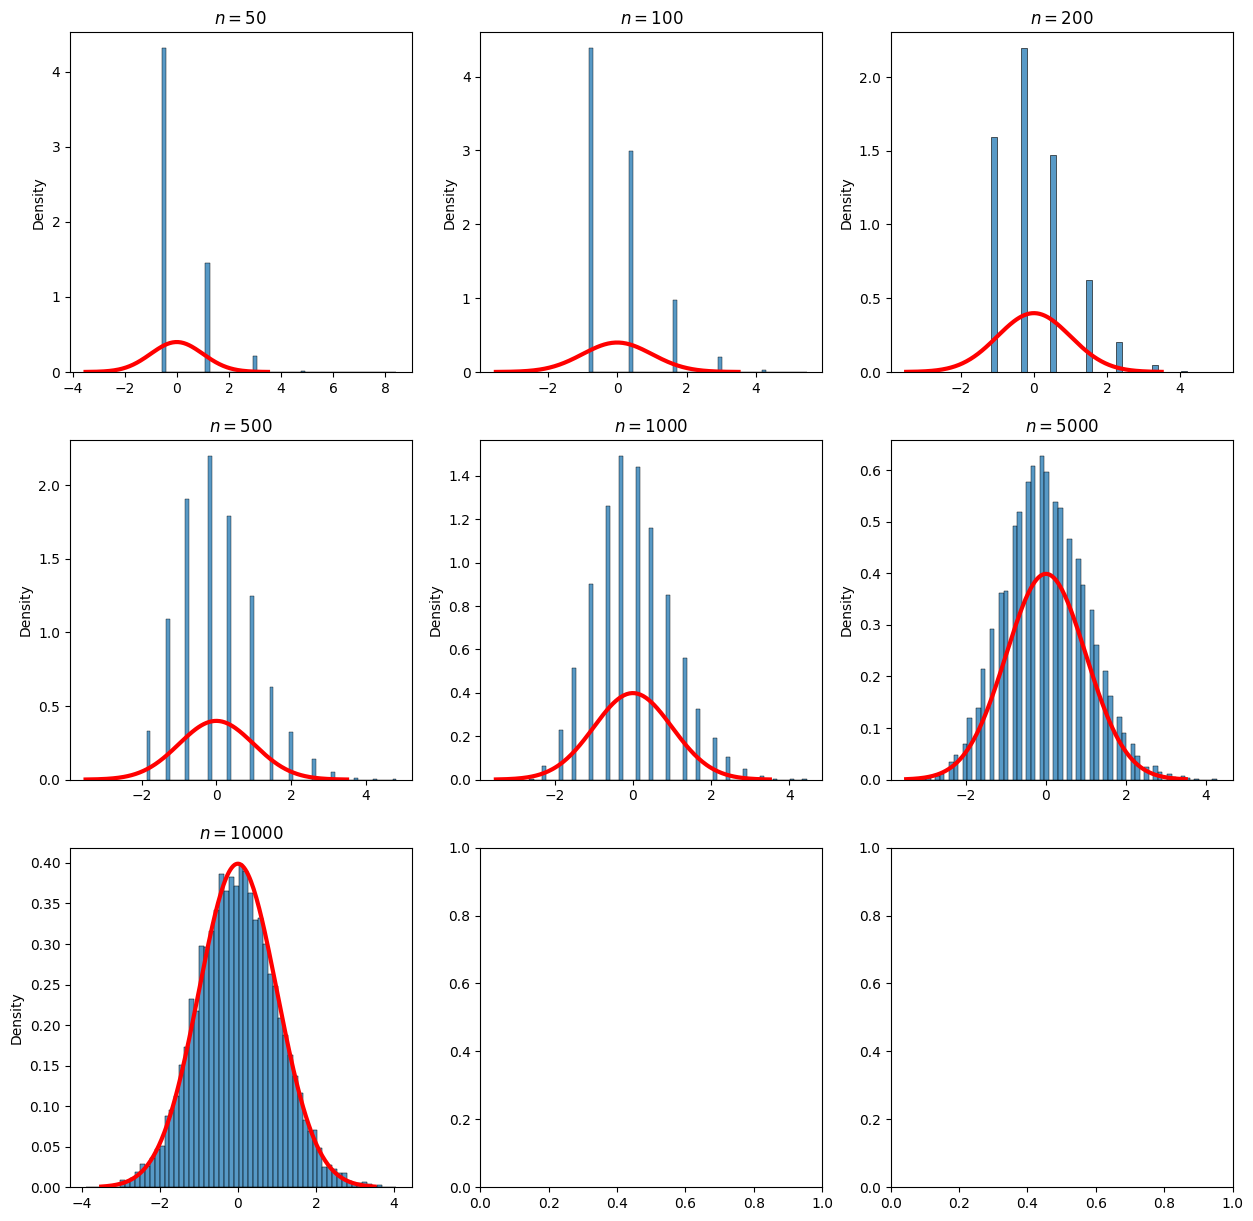

In [6]:
test_clt(5)

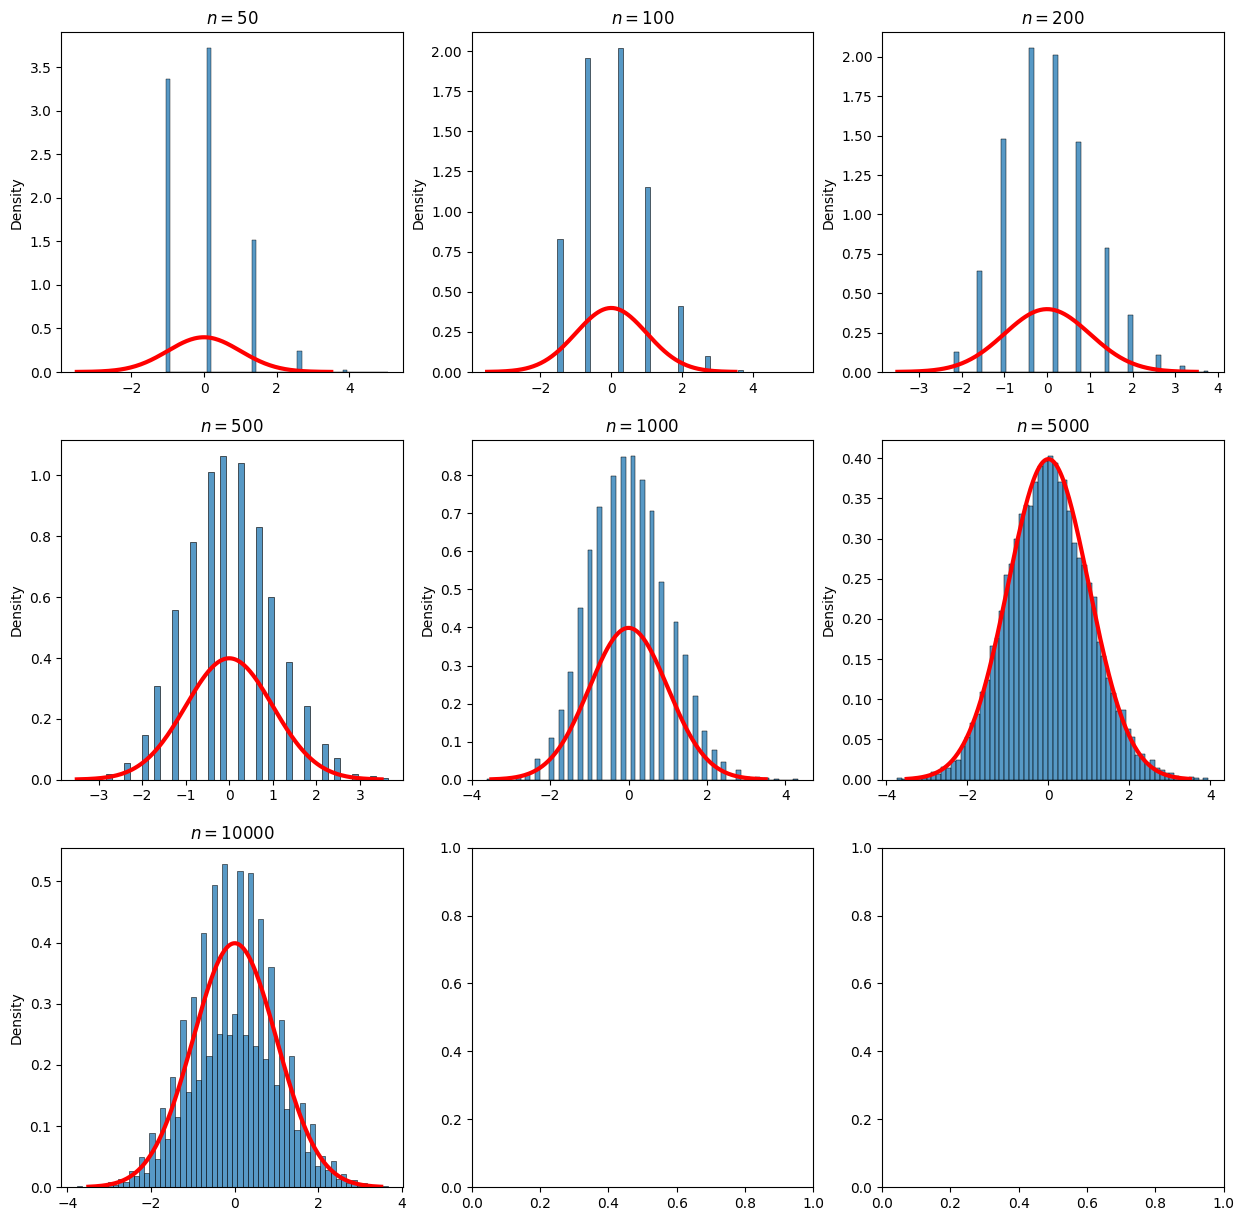

In [7]:
test_clt(1/5)

### Задание 3

In [8]:
def inf_pair_rvs(shape):
    u = st.uniform().rvs(shape)
    tr = np.ones(shape, int)
    fl = np.zeros(shape, int)
    x = np.where(u > 1/2, tr, fl)
    y = np.where((1/2 < u) & (u < 5/6), tr, fl)
    return (x, y)

In [9]:
N = 10_000_000
x, y = inf_pair_rvs(N)
print(x.mean())
print(y.mean())
print((x != y).mean())

0.5000411
0.3333588
0.1666823


### Задание 4

In [10]:
def test_Lindeberg(RV, K=1000, Ns=None):
    if Ns is None:
        Ns = [5, 10, 50, 100, 200, 500]
    ncols = 3
    nrows = len(Ns) // 3 + (1 if len(Ns) % 3 else 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    xs = np.linspace(-3.5, 3.5, 200)
    ys = st.norm.pdf(xs)
    for n, ax in zip(Ns, axes.ravel()):
        s = np.zeros(K)
        var = 0
        for j in range(1, n + 1):
            rv = RV(j)
            s += rv.rvs(K)
            var += rv.var()
        z = s / var**0.5
        ax.set_title(fr"$n = {n}$")
        ax.plot(xs, ys, c='r', lw=3)
        sns.histplot(z, stat='density', ax=ax)

In [11]:
class A:
    def __init__(self, n):
        self.n = n

    def var(self):
        return 1

    def rvs(self, shape=None):
        step1 = st.bernoulli(1 / (self.n)**2).rvs(shape)
        step2 = 2 * st.bernoulli(1 / 2).rvs(shape) - 1
        return step1 * step2 * self.n

In [12]:
class B:
    def __init__(self, n):
        self.n = n

    def var(self):
        return self.n**2 / 2

    def rvs(self, shape=None):
        step1 = st.bernoulli(1 / 2).rvs(shape)
        step2 = 2 * st.bernoulli(1 / 2).rvs(shape) - 1
        return step1 * step2 * self.n

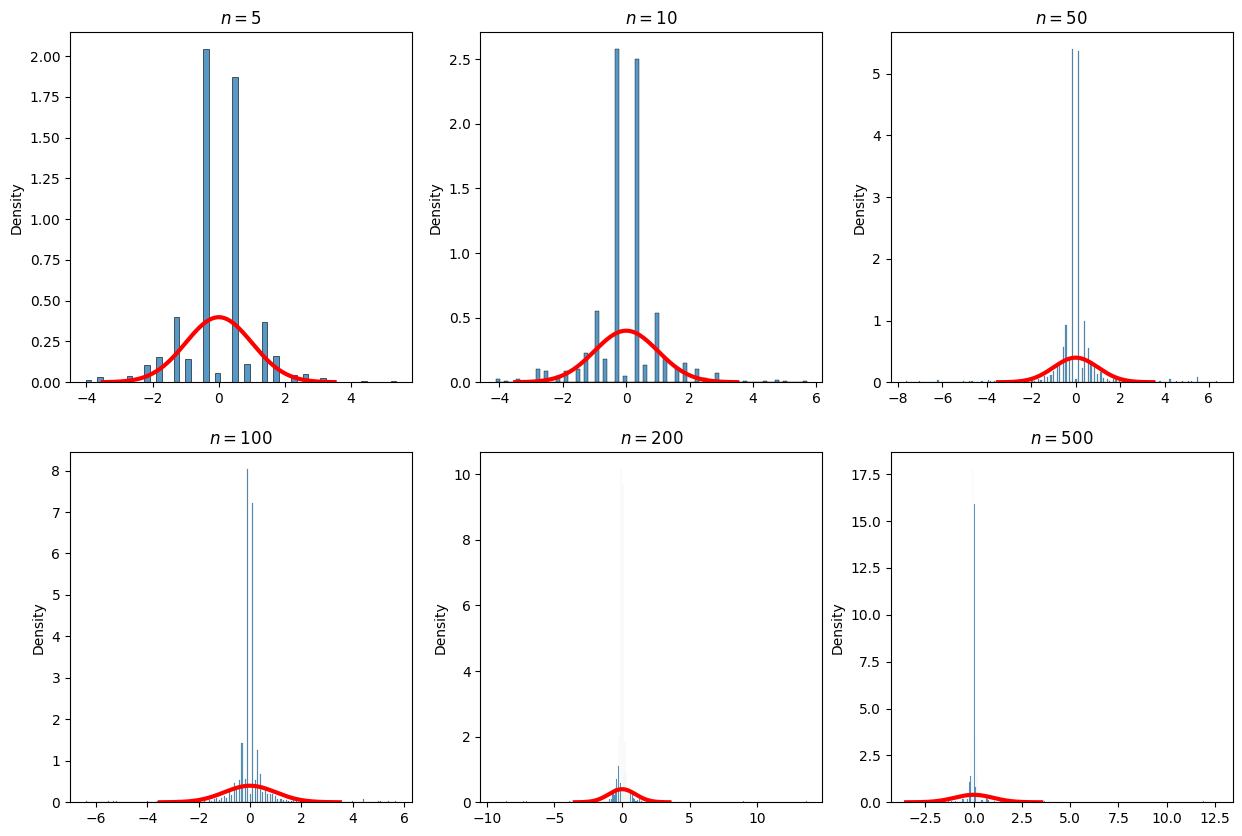

In [13]:
test_Lindeberg(A)

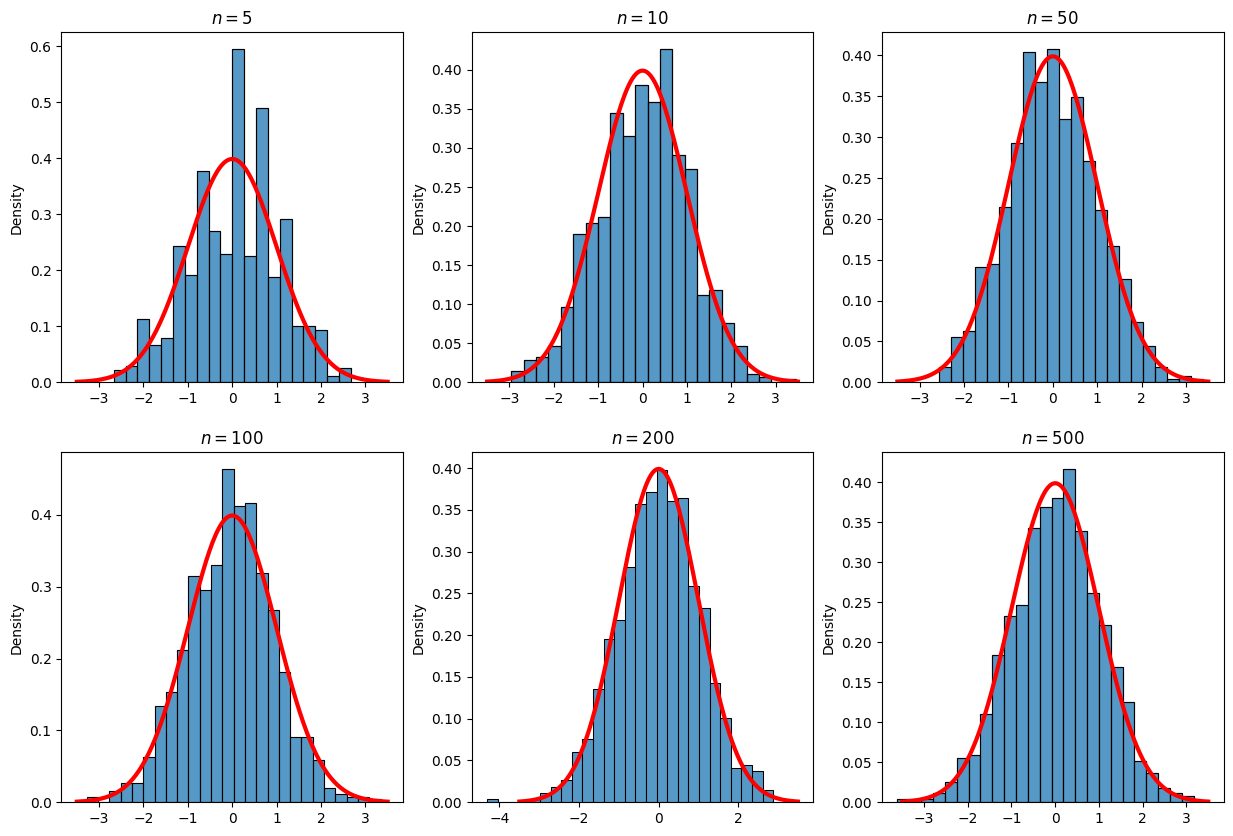

In [14]:
test_Lindeberg(B)

### Задание 5

In [15]:
def test_series(RV, check=None, stat='density', K=1000, Ns=None):
    if Ns is None:
        Ns = [5, 10, 50, 100, 200, 500]
    ncols = 3
    nrows = len(Ns) // 3 + (1 if len(Ns) % 3 else 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    for n, ax in zip(Ns, axes.ravel()):
        rv = RV(n)
        s = rv.rvs((K, n)).sum(axis=1)
        ax.set_title(fr"$n = {n}$")
        sns.histplot(s, stat=stat, ax=ax)
        if check is not None:
            x, y = check
            if stat == 'density':
                ax.plot(x, y, c='r', lw=3)
            elif stat == 'probability':
                ax.plot(x, y, 'o', c='r', ms=7)
                ax.vlines(x, 0, y, colors='r', lw=3)

In [16]:
def A(n):
    return st.geom(1 - 1 / n, loc=-1)

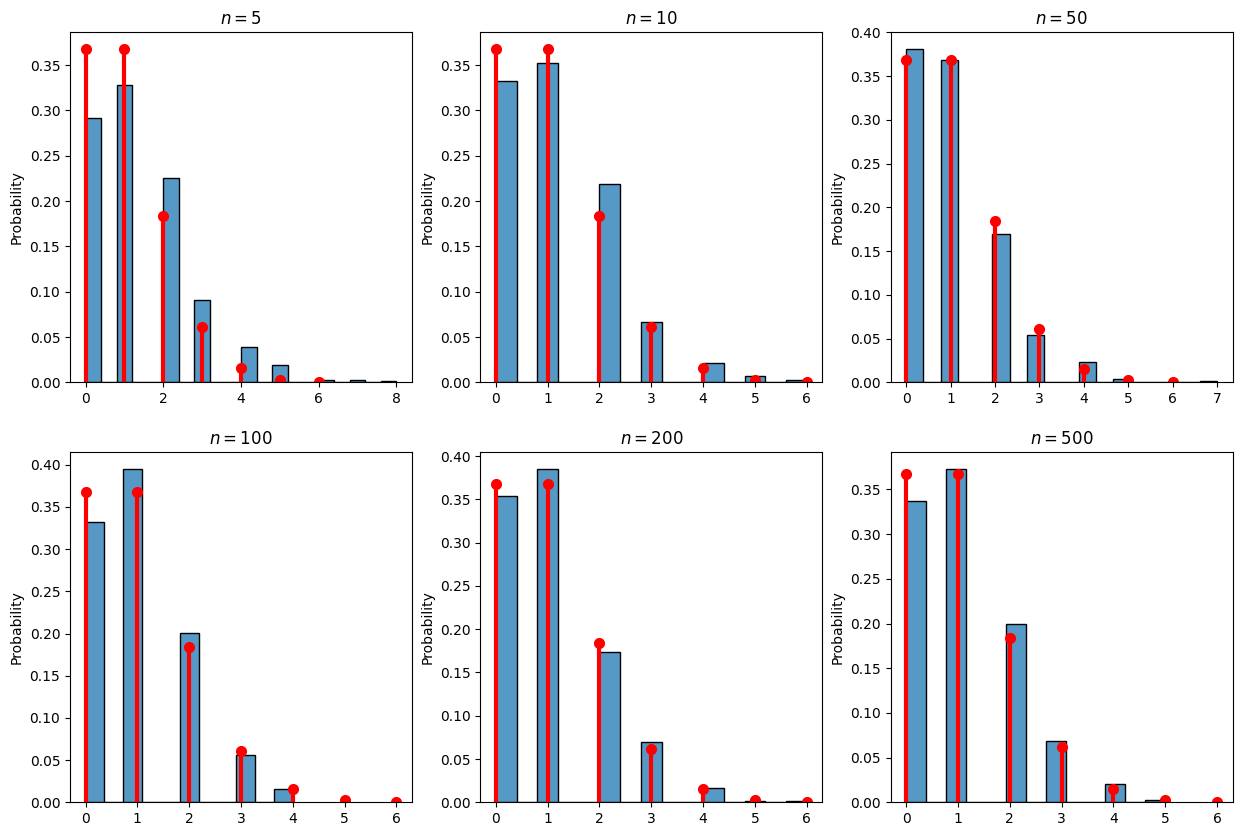

In [17]:
x = np.arange(0, 7, 1, int)
y = st.poisson(1).pmf(x) 
test_series(A, (x, y), 'probability')

In [18]:
class C:
    def __init__(self, n):
        self.n = n
        self.rv = st.nbinom(n, 1 / n)

    def rvs(self, shape=None):
        x = self.rv.rvs(shape) / self.n
        loc = self.n - 1
        scale = mt.sqrt(self.n * (self.n - 1))
        return (x - loc) / scale 

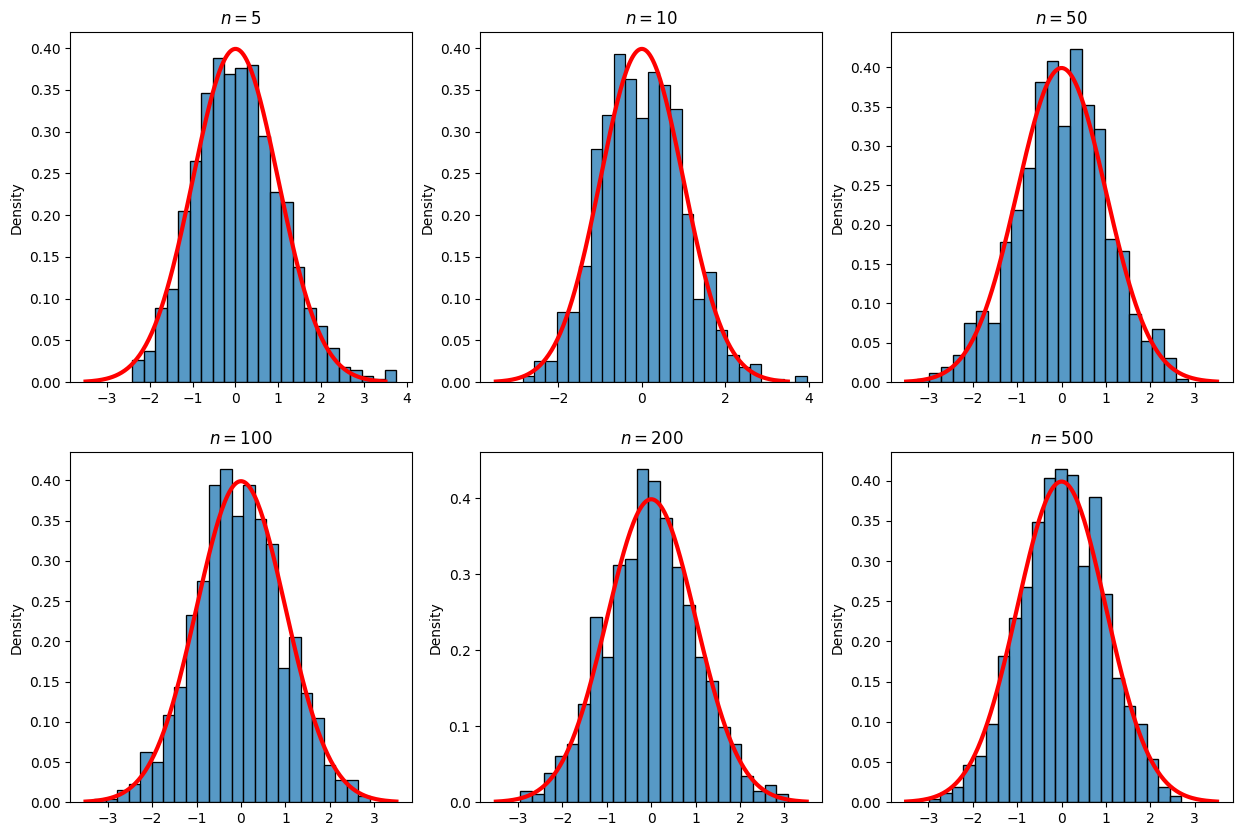

In [19]:
x = np.linspace(-3.5, 3.5, 200)
y = st.norm().pdf(x) 
test_series(C, (x, y), 'density')